<a href="https://colab.research.google.com/github/Vineelag2122/Machine-Learning/blob/main/Lab3_AP23110011644.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [2]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [3]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [5]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [6]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [7]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [8]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [9]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

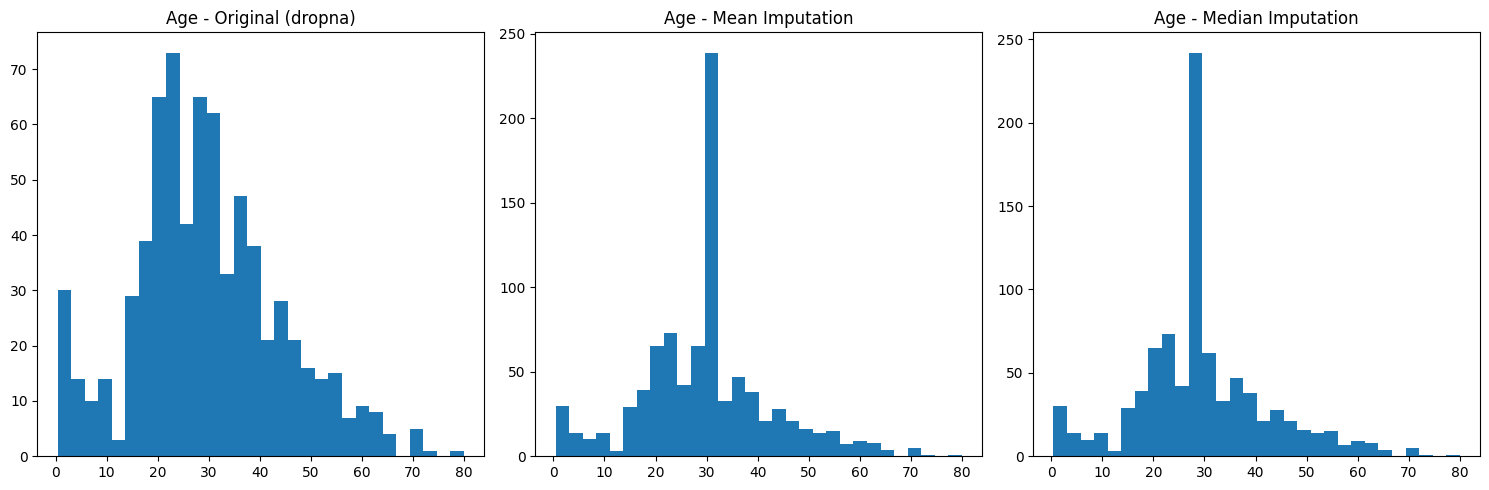

Original Embarked value counts:
 Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Embarked value counts after filling with 'Unknown':
 Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

Embarked value counts after filling with mode:
 Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


In [10]:
# Compare mean vs median imputation for Age
df_age_mean = df['Age'].fillna(df['Age'].mean())
df_age_median = df['Age'].fillna(df['Age'].median())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df['Age'].dropna(), bins=30)
axes[0].set_title('Age - Original (dropna)')

axes[1].hist(df_age_mean, bins=30)
axes[1].set_title('Age - Mean Imputation')

axes[2].hist(df_age_median, bins=30)
axes[2].set_title('Age - Median Imputation')

plt.tight_layout()
plt.show()

# Compare Embarked imputation with 'Unknown' vs mode
df_embarked_unknown = df['Embarked'].fillna('Unknown')
df_embarked_mode = df['Embarked'].fillna(df['Embarked'].mode()[0])

print("Original Embarked value counts:\n", df['Embarked'].value_counts())
print("\nEmbarked value counts after filling with 'Unknown':\n", df_embarked_unknown.value_counts())
print("\nEmbarked value counts after filling with mode:\n", df_embarked_mode.value_counts())

**Mean vs Median Imputation for Age:**
The median is less sensitive to outliers than the mean. Since the Age distribution might be skewed (as is common with age data, often with a tail towards older ages), imputing with the median is likely to preserve the original distribution's shape (especially the central tendency and spread) better than imputing with the mean. The mean can be pulled significantly by outliers, potentially distorting the distribution. Looking at the histograms generated by the code would show whether the median imputation results in a histogram that looks more similar to the original 'Age' distribution (excluding NaNs) compared to the mean imputation histogram.

**Embarked Imputation ('Unknown' vs Mode):**
Filling with the mode will increase the count of the most frequent category ('S' in this case) by the number of missing values (2). The value counts of the other categories will remain unchanged.
Filling with a new category like 'Unknown' will introduce a new category with a count equal to the number of missing values (2). The value counts of the original categories ('S', 'C', 'Q') will remain the same as in the original data (excluding NaNs).
In essence, median imputation is generally preferred for skewed numerical data to maintain the distribution's shape, while imputing with a new category for categorical data clearly separates the imputed values from the original categories, which can sometimes be more informative than simply adding them to the most frequent category.

## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

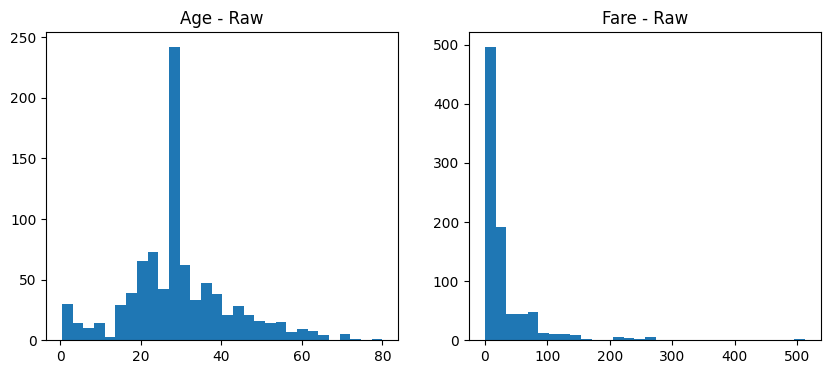

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

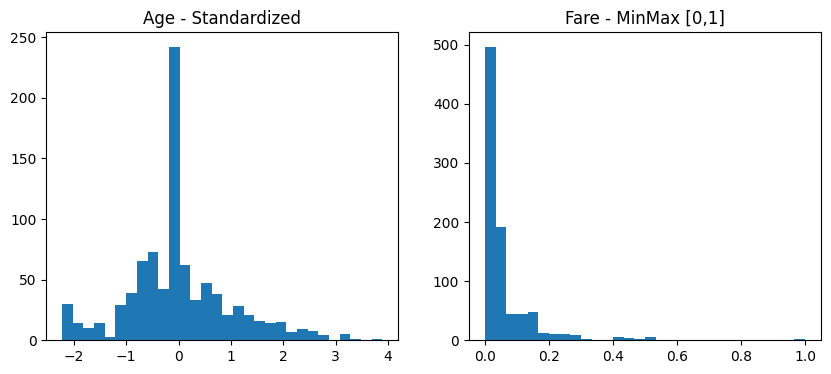

In [12]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

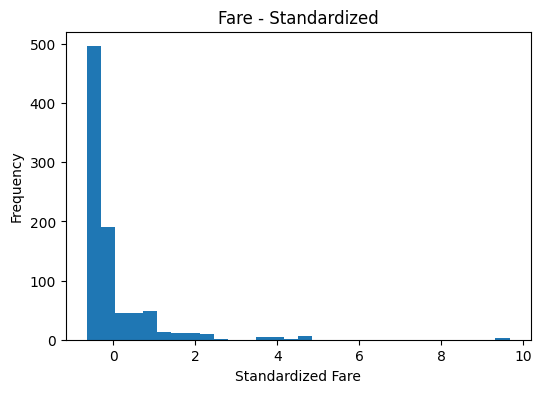

Mean of Standardized Fare: 3.987332972840069e-18
Standard Deviation of Standardized Fare: 1.0


In [13]:
#  Part 1: Standardize Fare and plot the histogram

sc_std_fare = StandardScaler()
fare_std = sc_std_fare.fit_transform(df_imp[['Fare']])

plt.figure(figsize=(6, 4))
plt.hist(fare_std.flatten(), bins=30)
plt.title('Fare - Standardized')
plt.xlabel('Standardized Fare')
plt.ylabel('Frequency')
plt.show()

print("Mean of Standardized Fare:", np.mean(fare_std))
print("Standard Deviation of Standardized Fare:", np.std(fare_std))

In [14]:
# Part 2: Apply Normalizer on [Age, Fare] rows

age_fare_df = df_imp[['Age', 'Fare']].copy()


normalizer = Normalizer()
age_fare_normalized = normalizer.fit_transform(age_fare_df)

age_fare_normalized_df = pd.DataFrame(age_fare_normalized, columns=['Age_normalized', 'Fare_normalized'])

# Check the first 5 normalized vectors
print("First 5 normalized [Age, Fare] vectors (L2 norm per row):")
display(age_fare_normalized_df.head())

print("\nL2 Norm of the first 5 normalized vectors:")
print(np.linalg.norm(age_fare_normalized[:5], axis=1))


First 5 normalized [Age, Fare] vectors (L2 norm per row):


,Age_normalized,Fare_normalized
0,0.949757,0.312988
1,0.470417,0.882444
2,0.956551,0.291564
3,0.550338,0.834942
4,0.974555,0.224148



L2 Norm of the first 5 normalized vectors:
[1. 1. 1. 1. 1.]


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [15]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [16]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

**Part-1 : Comparing the number of features for 'Embarked':**

With Ordinal Encoding, the 'Embarked' column is replaced by a single numeric column ('Embarked_ord'). With One-Hot Encoding, the 'Embarked' column is replaced by multiple binary columns, one for each unique category. Looking at the output of the get_dummies cell (cell fb67c353), you see three new columns for Embarked: Embarked_C, Embarked_Q, and Embarked_S. So, One-Hot encoding produced 3 features for 'Embarked'. Therefore, One-Hot encoding produced more features (3) than Ordinal encoding (1) for the 'Embarked' column.

**Part-2 : Why might one-hot be safer for linear models?** Linear models (like Linear Regression, Logistic Regression) work based on the assumption that there is a linear relationship between the features and the target variable.

When you use Ordinal Encoding on a categorical feature like 'Embarked' where there is no inherent order, you are assigning arbitrary integer values (e.g., C=0, Q=1, S=2). A linear model might then incorrectly interpret these numbers as having a numerical relationship (e.g., assuming that 'S' is "twice as much" as 'Q', or that the difference between 'S' and 'Q' is the same as the difference between 'Q' and 'C'). This false assumption can lead the model to learn incorrect weights and make poor predictions.

One-Hot Encoding avoids this problem. By creating separate binary columns, each category is treated independently. The model learns a separate coefficient (weight) for each category (e.g., a weight for Embarked_C, a weight for Embarked_Q, and a weight for Embarked_S). This allows the model to capture the effect of each category without assuming an ordered or linear relationship between them.

## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

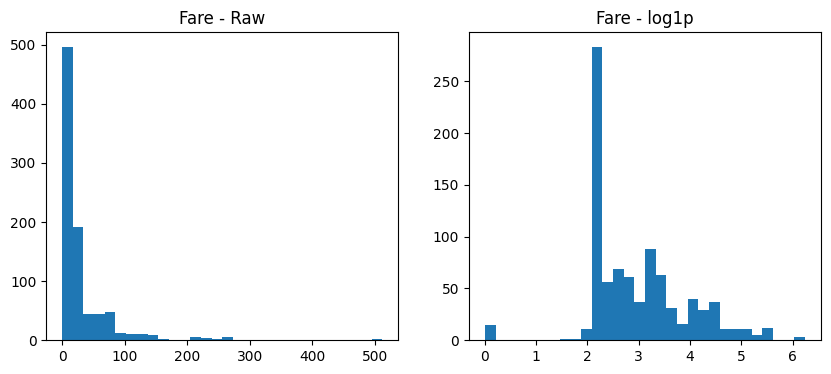

In [20]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

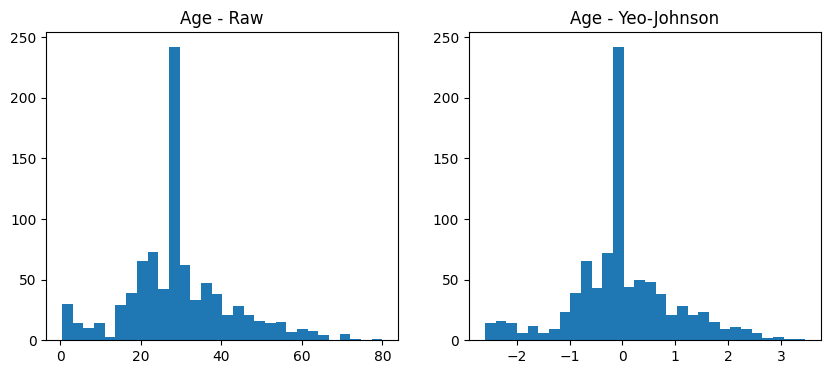

In [21]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [23]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

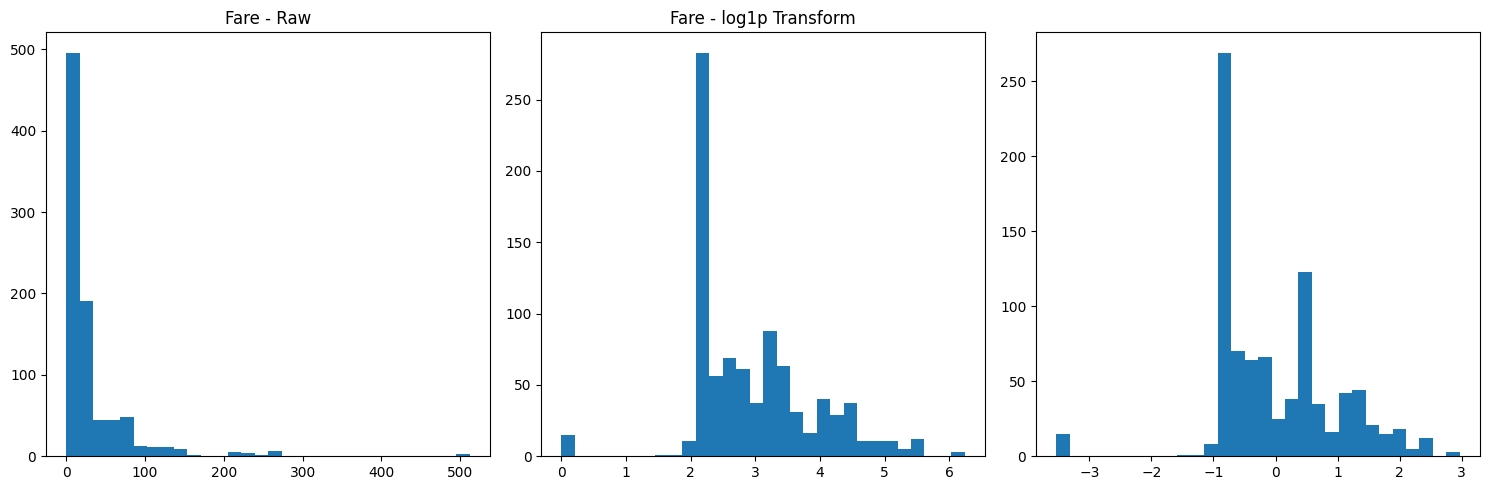

Skewness of original 'Fare': 4.787316519674893
Skewness of log1p transformed 'Fare': 0.3949280095189306
Skewness of power transformed 'Fare': -0.04032918275876422


In [24]:
# Part 1: Identify a skewed numeric column, apply log and power transforms, and compare histograms.

# We know 'Fare' is skewed based on previous visualizations.
skewed_col = 'Fare'
fare_data = df_imp[[skewed_col]].dropna() # Use df_imp with imputed values

fare_log = np.log1p(fare_data)

pt = PowerTransformer(method='yeo-johnson')
fare_pt = pt.fit_transform(fare_data)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(fare_data[skewed_col], bins=30)
axes[0].set_title(f'{skewed_col} - Raw')

axes[1].hist(fare_log.values.flatten(), bins=30)
axes[1].set_title(f'{skewed_col} - log1p Transform')

axes[2].hist(fare_pt.flatten(), bins=30)

plt.tight_layout()
plt.show()

print(f"Skewness of original '{skewed_col}':", fare_data[skewed_col].skew())
print(f"Skewness of log1p transformed '{skewed_col}':", pd.Series(fare_log.values.flatten()).skew())
print(f"Skewness of power transformed '{skewed_col}':", pd.Series(fare_pt.flatten()).skew())

**Part 2:** With PolynomialFeatures(2), which new terms are created from Age and Fare?

Looking at the output of the code cell b4d9c780 where PolynomialFeatures(degree=2, include_bias=False) was applied to ['Age','Fare'], the poly.get_feature_names_out(['Age','Fare']) output showed the generated feature names.

The original features were 'Age' and 'Fare'. With degree=2, Polynomial Features creates terms up to the second power and interaction terms.

The new terms created are:

**Age^2:** The square of the Age.

**Age Fare**: The interaction term between Age and Fare (Age multiplied by Fare).

**Fare^2:** The square of the Fare.

So, in addition to the original 'Age' and 'Fare' features, the PolynomialFeatures(2) transformer created 'Age^2', 'Age Fare', and 'Fare^2'.

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


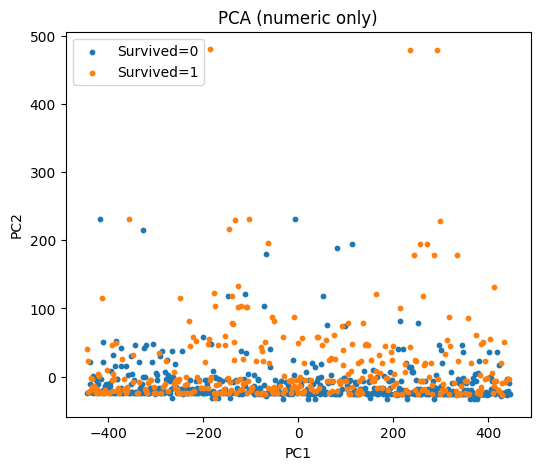

In [25]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [26]:
# Part 1: Which two numeric columns contribute the most variance before PCA?

numeric_df_imp = df_imp.select_dtypes(include=np.number)

variance_ranking = numeric_df_imp.var().sort_values(ascending=False)

print("Variance of numeric columns (sorted):")
print(variance_ranking)
print("\nTop two numeric columns by variance:")
print(variance_ranking.head(2))

Variance of numeric columns (sorted):
PassengerId    66231.000000
Fare            2469.436846
Age              169.512498
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64

Top two numeric columns by variance:
PassengerId    66231.000000
Fare            2469.436846
dtype: float64


In [27]:
# Part 2: Try PCA with n_components=3 and print the cumulative explained variance.

scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(numeric_df_imp)

# Apply PCA with 3 components
pca_3 = PCA(n_components=3, random_state=42)
Z_3 = pca_3.fit_transform(scaled_numeric_data)

print("\nExplained variance ratios for 3 components:", pca_3.explained_variance_ratio_)
print("Cumulative explained variance for 3 components:", np.sum(pca_3.explained_variance_ratio_))


Explained variance ratios for 3 components: [0.26661069 0.23447227 0.14282597]
Cumulative explained variance for 3 components: 0.6439089298577281


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).

In [29]:
# Step 1: Implement Preprocessing Steps

# Start with a fresh copy of the original DataFrame
df_processed = df.copy()

# 1) Impute: Age (median), Embarked (mode), Cabin ('Unknown').
df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])
df_processed['Cabin'] = df_processed['Cabin'].fillna('Unknown') # Although not used in later steps, keeping for completeness

# 2) Scale: standardize Age and min-max scale Fare.
# Need to reshape for StandardScaler and MinMaxScaler
age_scaled = StandardScaler().fit_transform(df_processed[['Age']])
fare_scaled = MinMaxScaler().fit_transform(df_processed[['Fare']])

# Replace original columns with scaled versions (or add new ones if preferred)
df_processed['Age_scaled'] = age_scaled
df_processed['Fare_scaled'] = fare_scaled

# 3) Encode: one-hot Sex and Embarked.
ohe_sex = pd.get_dummies(df_processed['Sex'], prefix='Sex', drop_first=True) # drop_first to avoid multicollinearity
ohe_embarked = pd.get_dummies(df_processed['Embarked'], prefix='Embarked', drop_first=True) # drop_first here too

# Concatenate the one-hot encoded columns to the processed DataFrame
df_processed = pd.concat([df_processed, ohe_sex, ohe_embarked], axis=1)

# Drop the original Sex and Embarked columns as they are now encoded
df_processed = df_processed.drop(['Sex', 'Embarked'], axis=1)

# 4) Transform: log1p Fare.
df_processed['Fare_log1p_scaled'] = np.log1p(df_processed['Fare_scaled'])


print("Processed DataFrame head:")
display(df_processed.head())

print("\nProcessed DataFrame info:")
df_processed.info()

print("\nProcessed DataFrame missing values:")
print(df_processed.isna().sum().sort_values(ascending=False))

Processed DataFrame head:


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_scaled,Fare_scaled,Sex_male,Embarked_Q,Embarked_S,Fare_log1p_scaled
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Unknown,-0.565736,0.014151,True,False,True,0.014052
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0.663861,0.139136,False,False,False,0.130270
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Unknown,-0.258337,0.015469,False,False,True,0.015350
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0.433312,0.103644,False,False,True,0.098618
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Unknown,0.433312,0.015713,True,False,True,0.015590



Processed DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Age                891 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Ticket             891 non-null    object 
 8   Fare               891 non-null    float64
 9   Cabin              891 non-null    object 
 10  Age_scaled         891 non-null    float64
 11  Fare_scaled        891 non-null    float64
 12  Sex_male           891 non-null    bool   
 13  Embarked_Q         891 non-null    bool   
 14  Embarked_S         891 non-null    bool   
 15  Fare_log1p_scaled  891 non-null    float64
dtyp

**Which step changed the data distribution the most?**

Looking back at the histograms plotted, the log1p transformation applied to the 'Fare' column had the most significant impact on changing the shape of the distribution, transforming it from heavily right-skewed to much more symmetrical. While scaling changes the range, it preserves the shape. Imputation adds values but ideally minimizes the change to the overall distribution shape.

**Which encoding produced more features, ordinal or one-hot? Why?**

As discussed in Exercise 4, One-Hot encoding produced more features for 'Embarked' (3 features: Embarked_C, Embarked_Q, Embarked_S) compared to Ordinal encoding (1 feature). This is because One-Hot encoding creates a separate binary column for each unique category, while Ordinal encoding maps all categories to a single integer column.